In [9]:
#LIBRARIES
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import math 
## FUZZY
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## nomalice parameters
from unidecode import unidecode

import spacy  # For preprocessing
from scipy import spatial
from time import time  # To time our operations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pylab as P

In [2]:
DF_JOB_H = pd.read_excel("4_final_db.xlsx")


In [3]:
DF_JOB_H["job_history_clean"]



0      [{'job_title': ' android developer', 'start': ...
1      [{'job_title': ' analyst', 'start': '2015'}, {...
2      [{'job_title': ' customer happiness', 'start':...
3      [{'job_title': ' cto', 'start': '2016'}, {'job...
4      [{'job_title': ' teacher assistant', 'start': ...
                             ...                        
539    [{'job_title': ' policy officer advisor qualit...
540    [{'job_title': ' computer technician', 'start'...
541    [{'job_title': ' educational content managemen...
542    [{'job_title': ' farm biochemist cytopathologi...
543    [{'job_title': ' ceo founder', 'start': '2014'...
Name: job_history_clean, Length: 544, dtype: object

In [5]:
## object maker
def stringToObject(DataFrame):
    #SEPARANDO LOS STRINGS DE CADA TRABAJO

    L = []

    for i in DataFrame.job_history_clean:
        l = str(i).split("},") #convertir en string el job history del individuo y crear lista para separar cada formación
        k = [] #Lista donde se almacenara cada formación x del individuo i
        for job in l: #para cada trabajo
            job = job.replace("[", "").replace("]", "") + "}" #separelos y conviertalas en diccionarios
            k.append(job) #añadalas a la lista de jobs
        L.append(k) 
    #EXTRAER DE MANERA ORDENADA EL JOB HISTORY, LA FECHA DE TERMINACIÓN Y COMIENZO
    K = [] 

    for individuo in tqdm(L): 

        educacion_ind = [] 

        for ins in individuo: 
            print(ins, type(ins))
            ins = ins.replace('"', "'")

            c = {}

            #EXTRAER JOB-TITLE
            if ( len(re.findall("'job_title': '.*?'", ins)) ) > 0:
                c["job_title"] =  re.findall("'job_title': '.*?'", ins)[0].replace("'job_title': ", "").replace("'", "")
                c["job_title"] = str(c["job_title"])
                # c["job_title"] = cleaning(c["job_title"])

            #EXTRAER INICIO
            if ( len(re.findall("'start': '.*?'", ins)) ) > 0:
                c["start"] = re.findall("'start': '.*?'", ins)[0].replace("'start': ", "").replace("'", "")
                c["start"] = int(c["start"][::-1][0:4][::-1]) #SOLO CONSERVAR EL AÑO 

            #EXTRAER FINALIZACIÓN
            if ( len(re.findall("'end': '.*?'", ins)) ) > 0:
                c["end"] = re.findall("'end': '.*?'", ins)[0].replace("'end': ", "").replace("'", "")
                c["end"] = int(c["end"][::-1][0:4][::-1]) #SOLO CONSERVAR EL AÑO

            educacion_ind.append(c) #añado cada formación a la lista de sus educaciones

        K.append(educacion_ind) #añado la educación de cada individuo a una lista general
    return K

    

In [6]:
result = stringToObject(DF_JOB_H)
print(result[0])


 laboratory analyst', 'start': '2012', 'end': '2012'} <class 'str'>
 {'job_title': ' chemical technician', 'start': '2009', 'end': '2012'}} <class 'str'>
{'job_title': ' scientific advisor', 'start': '2008'} <class 'str'>
 {'job_title': ' biologist', 'start': '1980', 'end': '2007'} <class 'str'>
 {'job_title': ' laboratory technique', 'start': '1983', 'end': '1984'} <class 'str'>
 {'job_title': ' laboratory technique act blood urine biochemistry', 'start': '1978', 'end': '1980'}} <class 'str'>
{'job_title': ' laboratory specialist jr', 'start': '2015'} <class 'str'>
 {'job_title': ' laboratory technician', 'start': '2013', 'end': '2015'} <class 'str'>
 {'job_title': ' laboratory technician', 'start': '2009', 'end': '2013'} <class 'str'>
 {'job_title': ' laboratory technician', 'start': '2008', 'end': '2009'} <class 'str'>
 {'job_title': ' laboratory technician', 'start': '2003', 'end': '2008'}} <class 'str'>
{'job_title': ' general manager', 'start': '2007'} <class 'str'>
100%|████████

In [7]:
type(result[0][0]["start"])

int

In [7]:
len(result)

389

In [10]:

embeddings_dict = {}
# vectors dimention
DIMENTION_DIC = 300
# 6 billions words
#with open("glove.6B."+str(DIMENTION_DIC)+"d.txt", 'r', encoding="utf-8") as f:
# 42 Billion words
with open("glove.42B."+str(DIMENTION_DIC)+"d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        print(word)
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

        

FileNotFoundError: [Errno 2] No such file or directory: 'glove.42B.300d.txt'

In [9]:
## ordena la spalabras dependiendo de la distancia euclidiana en el n-space
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

## method to get word/vector from dictionary
def getVectorWord(dictionary, word):
    if word in dictionary:
        return dictionary[word]
    else :
        return np.zeros(DIMENTION_DIC)


In [10]:
DF_JOB_H["end_boot"][200]

2015

In [11]:
## tranform profiles to vectors
profilesVectors = []
profilesVectorPlain = []
for index in range(0,len(result)):
    job_history_prof = result[index]
    boot_year = DF_JOB_H["end_boot"][index]
    boot_year = int(boot_year) if not type(boot_year) ==str  and not math.isnan(boot_year)  else float("nan")
    total_jobs = len(job_history_prof)
    job_vectors = []
    print(type(boot_year)== str,boot_year, )
    for i in range(0,total_jobs):
        if "start" in job_history_prof[i] and "job_title" in job_history_prof[i] and boot_year and not math.isnan(boot_year) and not type(boot_year) ==str and job_history_prof[i]["start"]>=int(boot_year):
            
            job_title = job_history_prof[i]["job_title"]
            print(job_title,len(job_title))
            nVectors = [np.zeros(DIMENTION_DIC)]
            if len(job_title) > 0:
                nVectors  = [ getVectorWord(embeddings_dict,word) for word in job_title.split()]
            sumVector = np.add.reduce(nVectors)
            job_vectors.append(sumVector)
            profilesVectorPlain.append(sumVector)
        else:
            profilesVectorPlain.append(np.zeros(DIMENTION_DIC))
            job_vectors.append(None)
    profilesVectors.append(job_vectors)



nager media manager 36
False 2017
False 2017
False 2014
 management consultant 22
False 2015
False 2016
False 2016
False 2017
False 2016
 project manager 16
False 2016
False 2016
False 2016
False 2015
False 2017
False 2016
 stack developer openspain 26
False 2017
False 2016
False 2016
False 2017
False 2016
False 2017
False 2016
 web development 16
False 2016
False 2017
False 2017
False 2016
 ui ux digital design intern 28
False 2016
False 2016
False 2016
False 2015
 end developer 14
 developer developer 20
False 2015
 graphic design 15
False 2017
False 2014
 web developer 14
 web developer 14
False 2016
 illumination 13
False 2016
False 2016
False 2017
False 2015
 ui ux designer 15
False 2012
False 2016
False 2015
 mobile developer 17
 ios developer 14
False 2017
False 2016
False 2017
False 2017
False 2016
 digital innovation lead 24
False 2017
False 2015
 javascript developer 21
False 2015
 senior ios developer 21
False 2017
False 2015
 system administrator 21
False 2014
 stack develo

In [12]:
len(profilesVectorPlain[0])

300

In [13]:
## number of words needed to pass
MIN_COUNT = 2
## validates if is word related
def validator(relatedWords, words):
    isRelated = False
    count = 0
    for word in words:
        if word in relatedWords:
            count+=1
        if count >= MIN_COUNT: 
            return True
    if count >= MIN_COUNT: 
        return True
    else:
        return False

 


In [14]:
print(find_closest_embeddings(profilesVectorPlain[1])[:9])

['4/0m', 'accesoriespopup', '1243map', '765.361.6100', 'drift.night', 'http://images.samsung.com/is/image/', 'http://images.samsung.com/is/', '12345678910111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989910010110210310410510610710810911011111211311411511611711811912012112212312412512612712812913013113213313413513613713813914014114214314414514614714814915015115215315415515615715815916016116216316416516616716816917017117217317417517617717817918018118218318418518618718818919019119219319419519619719819920020120220320420520620720820921021121221321421521621721821922022122222322422522622722822923023123223323423523623723823924024124224324424524624724824925025125225325425525625725825926026126226326426526626726826927027127227327427527627727827928028128228328428528628728828929029129229329429529629729829930030130230330430530630730830931031131231331431531631731831932032132

In [19]:
TOTAL_CLUSTERS = 12
#TOTAL_CLUSTERS = 4
dicC = {}
clusterTotal = np.zeros(len(profilesVectorPlain))

related_words = ["software","development","engineer","web","developers","developer","engineering","technical","java","computer","microsoft","technology","programmer"]
for clust in range(2, TOTAL_CLUSTERS+1):
    kmeans = KMeans(n_clusters=clust, random_state=0).fit(profilesVectorPlain)
    labels = kmeans.labels_
    relatedArray = []
    for index in range(0,len(kmeans.cluster_centers_)):
        words = find_closest_embeddings(kmeans.cluster_centers_[index])[:7]
        related = validator(related_words, words)
        print(index,related," - ",words)
        relatedArray.append(related)
    print(len(relatedArray),clust, len(clusterTotal))
    for proIndex in range(0,len(labels)):
        label = labels[proIndex]
        isRelated = relatedArray[label]
        if isRelated==True:
            print("isRelated")
            prev = clusterTotal[proIndex]
            clusterTotal[proIndex] = prev + 1
            print(prev,clusterTotal[proIndex])
    print("------------------------------------------\n")


4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
1.0 2.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
2.0 3.0
isRelated
4.0 5.0
isRelated
1.0 2.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
1.0 2.0
isRelated
0.0 1.0
isRelated
0.0 1.0
isRelated
0.0 1.0
isRelated
0.0 1.0
isRelated
1.0 2.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
1.0 2.0
isRelated
0.0 1.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
2.0 3.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
3.0 4.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
1.0 2.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
1.0 2.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
4.0 5.0
isRelated
1.0 2.0
isRelated
0.0 1.0
i

## max number in any job is 9, 

In [20]:
print(np.max(clusterTotal))

10.0


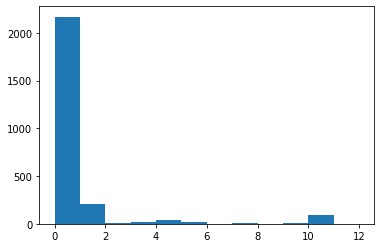

In [21]:

n, bins, patches = P.hist(clusterTotal,bins=[0,1,2,3,4,5,6,7,8,9,10,11,12])
P.show()

In [22]:
len(clusterTotal)

2575

In [23]:
len(profilesVectors[0])

3

## to group back the data


In [24]:
totalIndex = 0
finalDic = {}
finalDic["HAD_RELATED"] = []
finalDic["POSITIVE_JOBS"] = []
finalDic["POSIBLE_JOBS"] = []
finalDic["TOTAL_JOBS"] = []
for profile in profilesVectors:
    lenP = len(profile)
    #print("total JOBs", lenP)
    totalPosJobs = 0
    possibleJobs = 0
    hadRealted = False
    ## se recorre el array de jobs para este perfil
    for jobI in range(0,lenP):
        job = profile[jobI]
        print(jobI,type(job) )
        if  type(job) == np.ndarray : 
            countSingleJob = clusterTotal[totalIndex]
            print(countSingleJob)
            possibleJobs+=1
            if countSingleJob>4:
                hadRealted = True
                totalPosJobs+=1
            totalIndex+=1
        else:
            totalIndex+=1
    finalDic["HAD_RELATED"].append(hadRealted)
    finalDic["POSITIVE_JOBS"].append(totalPosJobs)
    finalDic["POSIBLE_JOBS"].append(possibleJobs)
    finalDic["TOTAL_JOBS"].append(lenP)

print(len(clusterTotal),totalIndex,finalDic)


darray'>
1.0
3 <class 'numpy.ndarray'>
1.0
4 <class 'numpy.ndarray'>
0.0
5 <class 'numpy.ndarray'>
1.0
6 <class 'numpy.ndarray'>
1.0
7 <class 'numpy.ndarray'>
0.0
8 <class 'numpy.ndarray'>
0.0
9 <class 'numpy.ndarray'>
1.0
10 <class 'numpy.ndarray'>
0.0
11 <class 'numpy.ndarray'>
0.0
12 <class 'numpy.ndarray'>
0.0
13 <class 'numpy.ndarray'>
1.0
14 <class 'numpy.ndarray'>
0.0
15 <class 'numpy.ndarray'>
0.0
16 <class 'numpy.ndarray'>
0.0
17 <class 'numpy.ndarray'>
0.0
18 <class 'numpy.ndarray'>
1.0
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'NoneType'>
4 <class 'NoneType'>
0 <class 'NoneType'>
0 <class 'numpy.ndarray'>
1.0
1 <class 'numpy.ndarray'>
1.0
2 <class 'numpy.ndarray'>
1.0
3 <class 'NoneType'>
4 <class 'NoneType'>
0 <class 'numpy.ndarray'>
0.0
1 <class 'numpy.ndarray'>
1.0
2 <class 'numpy.ndarray'>
1.0
3 <class 'NoneType'>
4 <class 'numpy.ndarray'>
0.0
5 <class 'NoneType'>
0 <class 'NoneType'>
1 <class 'NoneType'>
2 <class 'NoneType'>
3 <class 'NoneT

In [25]:

JOB_HIST_CLUS_DF = pd.DataFrame(finalDic)
JOB_HIST_CLUS_DF.to_excel("count_history_index.xlsx",index=False)
print(JOB_HIST_CLUS_DF, JOB_HIST_CLUS_DF.shape)

     HAD_RELATED  POSITIVE_JOBS  POSIBLE_JOBS  TOTAL_JOBS
0           True              1             1           3
1          False              0             1           5
2           True              1             2           4
3           True              1             2           7
4          False              0             1           1
..           ...            ...           ...         ...
539        False              0             0          11
540        False              0             0           3
541        False              0             0           2
542        False              0             0           2
543        False              0             0           6

[544 rows x 4 columns] (544, 4)


In [7]:
C1 = ["didactis", "educational assessment", "pedagogical","pre-school", "teachers", "primary", "class", "teacher training", "instructors"]

C2 = ['audio-visual techniques and media production','literature','linguistics','foreign languages','classical languages','interpretation','languages','philosophy ','ethics','history','archaeology','religion','theology','musicology','choreography','history of film and theatre','drama','music and performing arts','fine arts','audio-visual techniques','media production','fashion, interior and industrial design']

C3=['economics',
 'political sciences ',
 'civics',
 'psychology',
 'sociology ',
 'cultural studies',
 'journalism ',
 'reporting',
 'library, information ',
 'archival studies']


C4 = ['business',
 'administration',
 'finance',
 'banking',
 'insurance',
 'management',
 'administration',
 'marketing ',
 'advertising',
 'secretarial',
 'office work',
 'wholesale ',
 'retail sales',
 'work skills',
 'laws']
C5 = ['biology',
 'biochemistry',
 'environmental sciences',
 'natural environments',
 'wildlife',
 'chemistry',
 'earth sciences',
 'physics',
 'mathematics',
 'statistics']

C6 = ['information ',
 'communication technologies',
 'computer use',
 'database',
 'network design ',
 'software',
 'applications development',
 'analysis',
 'information and communication technologies ',
 'artificial intelligence']

C7 = ['nanotechnology',
 'manufacturing and processing',
 'food processing',
 'materials (glass, paper, plastic and wood)',
 'textiles (clothes, footwear and leather)',
 'architecture',
 'construction',
 'building',
 'civil engineering',
 'engineering',
 'engineering trades',
 'chemical engineering',
 'processes',
 'environmental protection technology',
 'electricity',
 'energy',
 'electronics',
 'automation',
 'mechanics',
 'metal trades',
 'motor vehicles, ships',
 'aircraf',
 'textiles (clothes, footwear and leather)']


C8 = ['agriculture',
 'crop',
 'livestock production',
 'horticulture',
 'forestry',
 'fisheries',
 'veterinary']


C9 = ['physiotherapy',
 'social work and counselling',
 'child care and youth services',
 'welfare',
 'pharmacy',
 'speech therapy',
 'nutrition/dietetics',
 'medical massage',
 'dietician programmes',
 'rehabilitation',
 'physiotherapy',
 'therapy and rehabilitation',
 'medical diagnostic and treatment technology',
 'nursing and midwifery',
 'orthodontics',
 'odontology',
 'dental assisting',
 'medical science',
 'gynaecology',
 'gerontology',
 'forensic medicine',
 'anaesthetics',
 'nursing and midwifery',
 'medicine',
 'dental studies']

C10 = ['domestic ',
 'hair',
 'beauty',
 'hotel',
 'restaurants',
 'catering',
 'sports',
 'travel, tourism',
 'leisure',
 'hygiene',
 'occupational health services',
 'occupational health',
 'safety',
 'military',
 'defence',
 'protection of persons',
 'property',
 'transport services']


In [8]:
#to vectors 
nlp = spacy.load("en_core_web_sm")

def cleaning(text):
    ##text = text.lower()
    #text = text.replace('[>/,\.!?\-!?\n\)\(\r]', ' ') 
    text = re.sub("[^A-Za-z']+", ' ', str(text))
    doc = nlp(text)
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    #txt = [token.lemma_ for token in doc if not token.is_stop]
    txt = [tok.lemma_.lower() for tok in doc
                if not tok.is_stop and not tok.is_punct and tok.is_alpha ]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    return txt

from deep_translator import GoogleTranslator
def translateString(to_translate, languageFinal):
    valid =isNaN(to_translate)
    print(valid)
    translated = GoogleTranslator(source='auto', target=languageFinal).translate("no" if valid else to_translate)
    return translated
def tranlateColum(dataFrame,columName,languageFinal):
    ## dataFrame Lengt
    total = dataFrame.shape[0]
    for i in range(0 ,total):
        to_translate = dataFrame[columName][i]
        translated = translateString(to_translate,languageFinal)
        print(i,to_translate,translated)
        dataFrame[columName][i] = None if translated == "no" else translated
def isNaN(testS):
    return not type(testS) == str and  math.isnan(testS)==True
def vectorCon(arrayStrings):
    totalC = []
    for word in arrayStrings:
        clean = translateString(word, "en")
        cleaned = cleaning(clean)
        nVectors = [np.zeros(DIMENTION_DIC)]
        if len(cleaned) > 0:
            nVectors  = [ getVectorWord(embeddings_dict,word) for word in cleaned]
        sumVector = np.add.reduce(nVectors)
        totalC.append(sumVector)
    print(len(totalC))
    return np.add.reduce(totalC)


NameError: name 'spacy' is not defined